In [1]:
import pyrootutils
import os

# Set the project root using the current working directory
project_root = pyrootutils.setup_root(os.getcwd(), indicator=".git", pythonpath=True, cwd=True)
print("Working directory set to:", os.getcwd())

Working directory set to: /home/ec2-user/embedding-adapter


In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import torch
import pandas as pd

from embedding_adapter.csts_module import CSTSQuadModule

/home/ec2-user/embedding-adapter/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load the sentence adapter from the checkpoint
checkpoint_path = f"logs/csts/triplet_model_2025-05-13_12-51-58_3f9298/checkpoints/triplet-model-epoch-0009.ckpt"
adapter_model = CSTSQuadModule.load_from_checkpoint(checkpoint_path, map_location=torch.device('cuda'))
adapter_model.eval()
dtype = adapter_model.dtype
adapter = adapter_model.adapter

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def cosine_similarity_matrix(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:
    norm_tensor1 = tensor1 / tensor1.norm(dim=1, keepdim=True)
    norm_tensor2 = tensor2 / tensor2.norm(dim=1, keepdim=True)
    return torch.mm(norm_tensor1, norm_tensor2.t())

In [7]:
def pairwise_cosine_similarity(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:
    norm_tensor1 = tensor1 / tensor1.norm(dim=1, keepdim=True)
    norm_tensor2 = tensor2 / tensor2.norm(dim=1, keepdim=True)
    return torch.sum(norm_tensor1 * norm_tensor2, dim=1)

### Evaluate on C-STS Dataset

In [19]:
embedding_model_name = "sfr"
train_df = pd.read_parquet(f"data/csts/{embedding_model_name}/csts_train.parquet")
val_df = pd.read_parquet(f"data/csts/{embedding_model_name}/csts_val.parquet")
test_df = pd.read_parquet(f"data/csts/{embedding_model_name}/csts_test.parquet")

FileNotFoundError: [Errno 2] No such file or directory: 'data/csts/sfr/csts_train.parquet'

In [9]:
train_df.columns

Index(['sentence1', 'sentence2', 'condition', 'label', 'sentence1_embedding',
       'sentence2_embedding', 'condition_embedding'],
      dtype='object')

In [10]:
device="cuda"

In [11]:
def get_embedding_tensors(df):
    sentence1_embeddings = torch.tensor(np.stack(df['sentence1_embedding']), dtype=torch.float32).to(device=device).detach()
    sentence2_embeddings = torch.tensor(np.stack(df['sentence2_embedding']), dtype=torch.float32).to(device=device).detach()
    condition_embeddings = torch.tensor(np.stack(df['condition_embedding'])).to(dtype=dtype, device=device).detach()
    return sentence1_embeddings, sentence2_embeddings, condition_embeddings

In [12]:
train_embeddings = get_embedding_tensors(train_df)
val_embeddings = get_embedding_tensors(val_df)
test_embeddings = get_embedding_tensors(test_df)

In [13]:
cosine_similarities_train = pairwise_cosine_similarity(train_embeddings[0], train_embeddings[1])

In [14]:
cosine_similarities_val = pairwise_cosine_similarity(val_embeddings[0], val_embeddings[1])

In [15]:
cos_sim_train = cosine_similarities_train.cpu().numpy()
cos_sim_val = cosine_similarities_val.cpu().numpy()

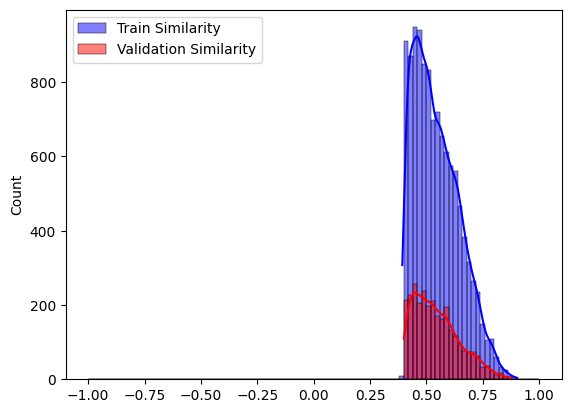

In [16]:
sns.histplot(cos_sim_train, binwidth=0.02, binrange=(-1, 1), color='blue',kde=True, label='Train Similarity')
sns.histplot(cos_sim_val, binwidth=0.02, binrange=(-1, 1), color='red', kde=True, label='Validation Similarity')
plt.legend()
plt.show()

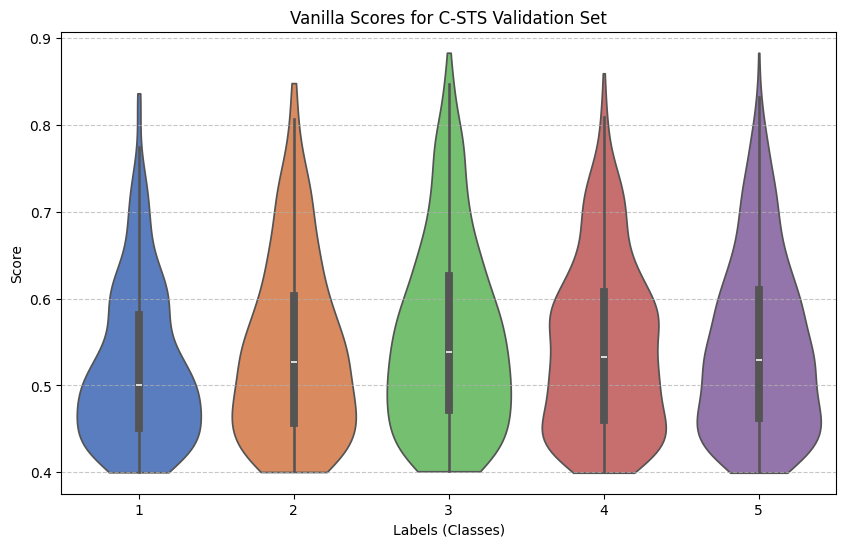

In [17]:
plt.figure(figsize=(10, 6))
sns.violinplot(x=val_df['label'], hue=val_df['label'], y=cos_sim_val, palette="muted", legend=False, cut=0.02)
plt.xlabel("Labels (Classes)")
plt.ylabel("Score")
plt.title("Vanilla Scores for C-STS Validation Set")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

# Compute the Spearman correlation
correlation, _ = spearmanr(cos_sim_val, val_df['label'])
print(f"Spearman Correlation: {correlation}")

# Compute the Spearman correlation
correlation, _ = pearsonr(cos_sim_val, val_df['label'])
print(f"Pearson Correlation: {correlation}")

Spearman Correlation: 0.05092082280645824
Pearson Correlation: 0.05661250339189913


In [23]:
def get_adapted_embeddings(sentence1_embeddings, sentence2_embeddings, condition_embeddings):
    with torch.inference_mode():
        gates = adapter.forward_gate(condition_embeddings)
        adapted_sentence1_embeddings = adapter.forward_adapter(sentence1_embeddings.to(dtype=dtype), gates.to(dtype=dtype))
        adapted_sentence2_embeddings = adapter.forward_adapter(sentence2_embeddings.to(dtype=dtype), gates.to(dtype=dtype))
    return adapted_sentence1_embeddings, adapted_sentence2_embeddings

In [24]:
adapted_train_embeddings = get_adapted_embeddings(*train_embeddings)
adapted_val_embeddings = get_adapted_embeddings(*val_embeddings)
adapted_test_embeddings = get_adapted_embeddings(*test_embeddings)

In [25]:
adapted_cosine_similarities_train = pairwise_cosine_similarity(*adapted_train_embeddings)

In [26]:
adapted_cosine_similarities_val = pairwise_cosine_similarity(*adapted_val_embeddings)

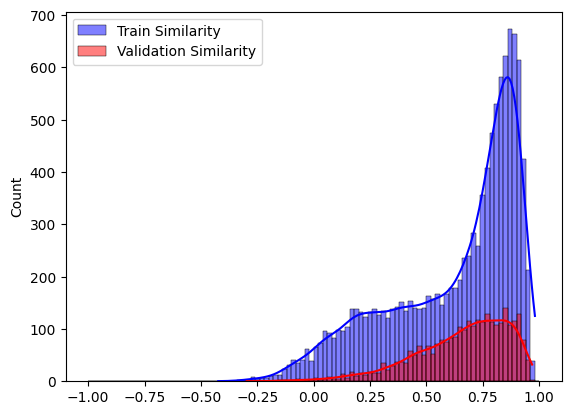

In [27]:
sns.histplot(adapted_cosine_similarities_train.cpu().numpy(), binwidth=0.02, binrange=(-1, 1), color='blue', kde=True, label='Train Similarity')
sns.histplot(adapted_cosine_similarities_val.cpu().numpy(), binwidth=0.02, binrange=(-1, 1), color='red', kde=True, label='Validation Similarity')
plt.legend()
plt.show()

In [28]:
adapted_cos_sim_train = adapted_cosine_similarities_train.cpu().numpy()
adapted_cos_sim_val = adapted_cosine_similarities_val.cpu().numpy()

In [29]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

# Compute the Spearman correlation
correlation, _ = spearmanr(adapted_cos_sim_val, val_df['label'])
print(f"Spearman Correlation: {correlation}")

# Compute the Spearman correlation
correlation, _ = pearsonr(adapted_cos_sim_val, val_df['label'])
print(f"Pearson Correlation: {correlation}")

Spearman Correlation: 0.3708325534594877
Pearson Correlation: 0.36917511315026513


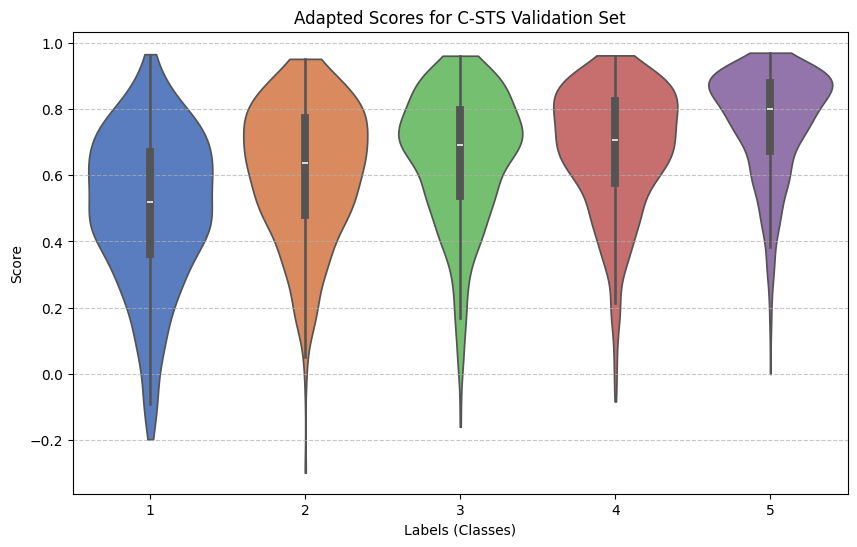

In [30]:
plt.figure(figsize=(10, 6))
sns.violinplot(x=val_df['label'], hue=val_df['label'], y=adapted_cos_sim_val, palette="muted", legend=False, cut=0.02)
plt.xlabel("Labels (Classes)")
plt.ylabel("Score")
plt.title("Adapted Scores for C-STS Validation Set")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

### Submit Test

In [31]:
adapted_cosine_similarities_test = pairwise_cosine_similarity(*adapted_test_embeddings)
adapted_cos_sim_test = adapted_cosine_similarities_test.cpu().numpy()

In [32]:
predicted_scores = 2 * adapted_cos_sim_test + 3
print(predicted_scores)

[4.8007607 4.7326303 3.474617  ... 4.4619465 4.759022  4.685897 ]


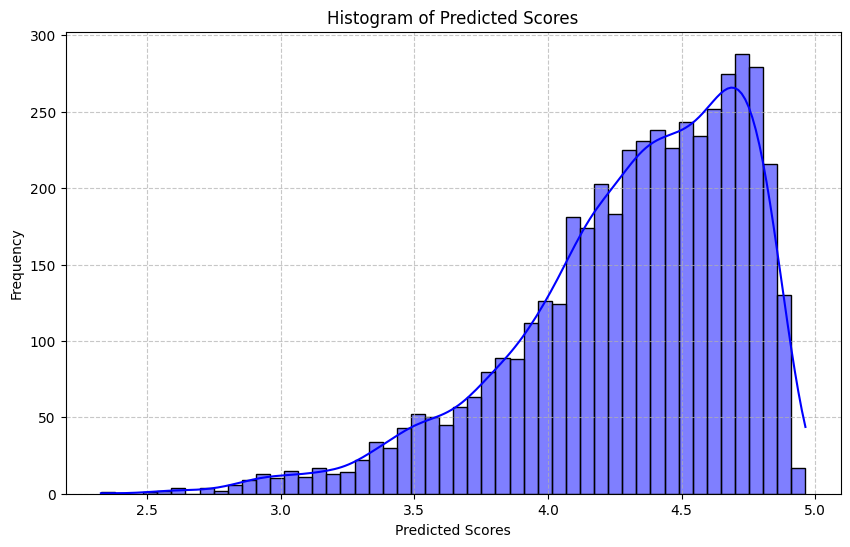

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(predicted_scores, bins=50, kde=True, color='blue')
plt.title("Histogram of Predicted Scores")
plt.xlabel("Predicted Scores")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [34]:
assert len(predicted_scores) == 4732, "Make sure the number of predicted scores matches the number of test samples."

In [35]:
import re
import json
import requests


def send_post_request(email, predictions, filename):
    # Prepare the data to be sent
    if len(filename) > 200:
        raise ValueError('Submission name (%s) longer than 200 characters. Please choose a shorter filename or set the name with --name' % filename)
    data = {
        'email': email,
        'predictions': predictions,
        'filename': filename,
    }
    data_str = json.dumps({'body': json.dumps(data)})
    headers = {'content-type': 'application/json'}
    # url = 'https://rcxnewlbk5.execute-api.us-east-2.amazonaws.com/test/eval-csts'
    url = "https://0sy74d2tog.execute-api.us-east-2.amazonaws.com/dev/c-sts-eval-lambda"
    # Create the request object
    request_object = {
        "url": url,
        "headers": headers,
        "data": data
    }
    json.dump(request_object, open('request.json', 'w'), indent=4)
    response = requests.post(url, headers=headers, data=data_str)    
    if response.status_code == 200:
        print("Evaluation successful!")
        print(response.json()['body'])
        print("See email: \"C-STS Evaluation Results for %s\"" % filename)

def submit(email, predictions, name):
    if not re.match(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+(?:[A-Za-z0-9.-]+)*\b", email):
        raise ValueError("Email %s is invalid" % email)
    if len(predictions) != 4732:
        raise ValueError("There should be exactly 4732 predictions, but got %d instead" % len(predictions))
    send_post_request(email, predictions, name)

In [ ]:
submit("anon@anon.edu", predicted_scores.tolist(), "testv1")

Evaluation successful!
{"MSE": 2.5540060501287125, "spearmanr": 0.3805712669499781, "pearsonr": 0.3776287829993503}
See email: "C-STS Evaluation Results for testv1"
